# Demo

In [339]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [340]:
import financial.data as fd
import financial.model as fm

import numpy as np
import pandas as pd
import os

In [341]:
from financial.io.cache import NoUpdateStrategy
from financial.io.file.cache import FileCache

print(os.environ["DATA"])
print(os.environ["CACHE"])
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))

print(ds)

/home/manidmt/Universidad/TFG/OTRI/data
/home/manidmt/Universidad/TFG/OTRI/cache
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


## Acceso a los datos

In [342]:
# Datos históricos de un ticker concreto, p.ej. ^GSPC (S&P 500)
start_date = '1990-01-01'
end_date = '2023-12-31'
ticker = '^GSPC'

data = ds.get_data(ticker, start_date, end_date)
print(data)

1990-01-02     359.690002
1990-01-03     358.760010
1990-01-04     355.670013
1990-01-05     352.200012
1990-01-08     353.790009
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: ^GSPC, Length: 8565, dtype: float64


^GSPC, from 1990-01-02 to 2023-12-29


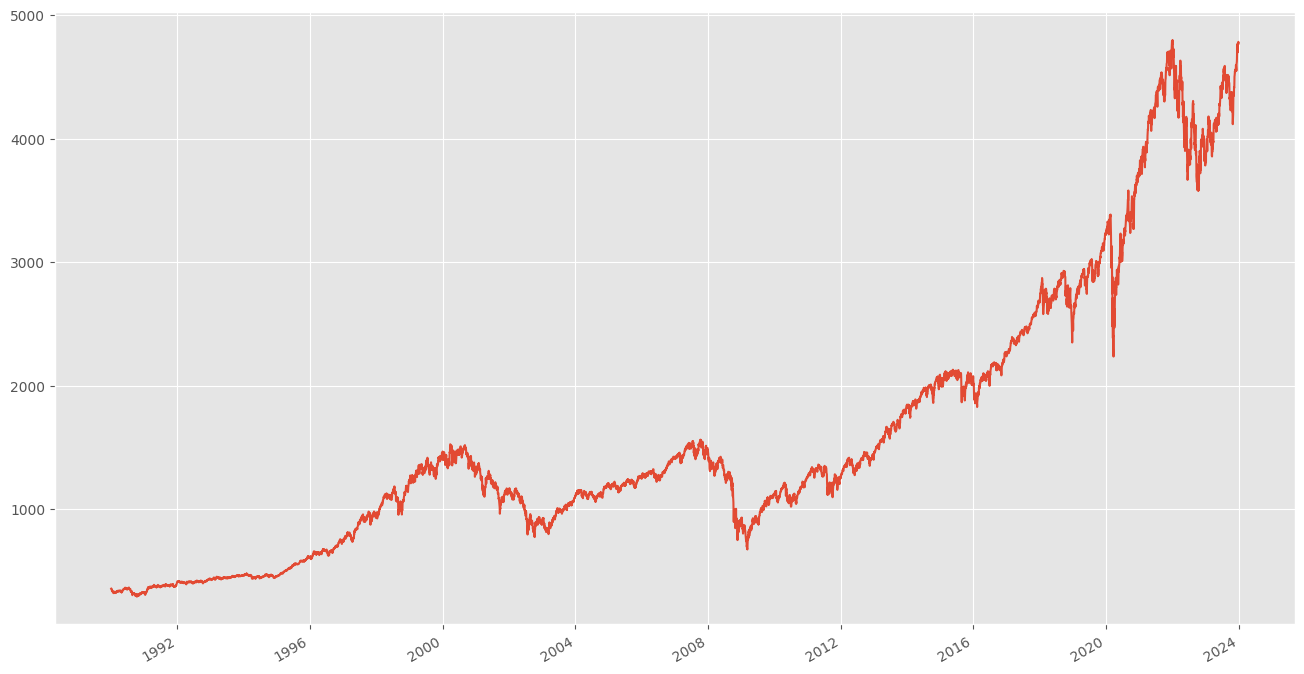

In [343]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')


def plot_data(data: pd.Series) -> None:
    data.plot()
    start_date = data.index[0].date()
    end_date = data.index[-1].date()
    print(f"{data.name}, from {start_date} to {end_date}")

plot_data(data)

# Hiperparámetros

In [344]:
# Declarative model specification

experiment_id = 'ar-model'
lookahead = 20 # i.e. ~ 1 mes (4 semanas)
horizon   = -1 # i.e. ~ 1 mes (4 semanas)

hyperparameters = {
        "input": {
            "features": "baseline_features",
            "horizon": horizon,
            "ticker": ticker,
            "normalization": { "method": "z-score", "start_index": start_date, "end_index": end_date }
            },
        "output": {
            "target": [ticker],
            "lookahead": lookahead,
            "prediction": "relative", # "absolute"|"relative"
            "normalization": { "method": "z-score", "start_index": start_date, "end_index": end_date }
            },    
}

print(f"Experiment '{experiment_id}'")
print(hyperparameters)

Experiment 'ar-model'
{'input': {'features': 'baseline_features', 'horizon': -1, 'ticker': '^GSPC', 'normalization': {'method': 'z-score', 'start_index': '1990-01-01', 'end_index': '2023-12-31'}}, 'output': {'target': ['^GSPC'], 'lookahead': 20, 'prediction': 'relative', 'normalization': {'method': 'z-score', 'start_index': '1990-01-01', 'end_index': '2023-12-31'}}}


# E/S de un modelo autorregresivo

In [345]:
# Entradas 
'''
def baseline_features(ds: fd.DataStore, hyperparameters: dict) -> fd.Set:
    features = fd.Set('Baseline features')
    
    ticker = hyperparameters["input"]["ticker"]
    horizon = hyperparameters["input"]["horizon"]
    #features.append(variable)
    variable = fd.Variable(ticker)
    for i in range(1, horizon+1): 
        features.append( fd.Change(variable, i) )

    return features


print("MODEL INPUTS")
inputs = baseline_features(ds,hyperparameters)
print(inputs)
print(inputs.to_xml_string())

from financial.lab.preprocessing import DataStoreDataNormalization

def standardized_features(ds: fd.DataStore, features: fd.Set) -> fd.Set:
    if "normalization" in hyperparameters["input"]:
        normalization = hyperparameters["input"]["normalization"]
        method = normalization["method"]
        start_index = normalization["start_index"]
        end_index = normalization["end_index"]
        normalizer = DataStoreDataNormalization("ModelFactory", ds, features, method, start_index, end_index)
        features = normalizer.normalized()
    return features



print("STANDARDIZED MODEL INPUTS")
standardized_inputs = standardized_features(ds, inputs)
print(standardized_inputs)
print(standardized_inputs.to_xml_string())
'''

'\ndef baseline_features(ds: fd.DataStore, hyperparameters: dict) -> fd.Set:\n    features = fd.Set(\'Baseline features\')\n    \n    ticker = hyperparameters["input"]["ticker"]\n    horizon = hyperparameters["input"]["horizon"]\n    #features.append(variable)\n    variable = fd.Variable(ticker)\n    for i in range(1, horizon+1): \n        features.append( fd.Change(variable, i) )\n\n    return features\n\n\nprint("MODEL INPUTS")\ninputs = baseline_features(ds,hyperparameters)\nprint(inputs)\nprint(inputs.to_xml_string())\n\nfrom financial.lab.preprocessing import DataStoreDataNormalization\n\ndef standardized_features(ds: fd.DataStore, features: fd.Set) -> fd.Set:\n    if "normalization" in hyperparameters["input"]:\n        normalization = hyperparameters["input"]["normalization"]\n        method = normalization["method"]\n        start_index = normalization["start_index"]\n        end_index = normalization["end_index"]\n        normalizer = DataStoreDataNormalization("ModelFactory",

In [346]:
# Salidas 
'''
def output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:
    outputs = fd.Set('outputs')
    for output in hyperparameters["output"]["target"]:
        variable = fd.Variable(output) 
        lookahead = hyperparameters["output"]["lookahead"]
        target = fd.LookAhead(variable, lookahead)
        outputs.append( target )            
    return outputs


outputs = output_descriptor(hyperparameters, ds)
print(outputs)
print(outputs.to_xml_string())
print(outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])
print(data[lookahead:])


def change_output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:
    outputs = fd.Set('outputs')
    for output in hyperparameters["output"]["target"]:
        variable = fd.Variable(output) 
        lookahead = hyperparameters["output"]["lookahead"]
        target = fd.Change(variable, -lookahead)
        outputs.append( target )            
    return outputs

def standardized_output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:
    outputs = fd.Set('outputs')

    for output in hyperparameters["output"]["target"]:
        variable = fd.Variable(output) 
        lookahead = hyperparameters["output"]["lookahead"]
        target = fd.Change(variable, -lookahead)
        outputs.append( target )            

    if "normalization" in hyperparameters["output"]:
        normalization = hyperparameters["output"]["normalization"]
        method = normalization["method"]
        start_index = normalization["start_index"]
        end_index = normalization["end_index"]
        normalizer = DataStoreDataNormalization("ModelFactory", ds, outputs, method, start_index, end_index)
        outputs = normalizer.normalized()
    
    return outputs


change_outputs = change_output_descriptor(hyperparameters, ds)
print(change_outputs)
print(change_outputs.to_xml_string())
print(change_outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])

standardized_outputs = standardized_output_descriptor(hyperparameters, ds)
print(standardized_outputs)
print(standardized_outputs.to_xml_string())
print(standardized_outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])
print(standardized_outputs.variables[0].get_data(ds,start_date, end_date)[lookahead:-lookahead])
'''

'\ndef output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:\n    outputs = fd.Set(\'outputs\')\n    for output in hyperparameters["output"]["target"]:\n        variable = fd.Variable(output) \n        lookahead = hyperparameters["output"]["lookahead"]\n        target = fd.LookAhead(variable, lookahead)\n        outputs.append( target )            \n    return outputs\n\n\noutputs = output_descriptor(hyperparameters, ds)\nprint(outputs)\nprint(outputs.to_xml_string())\nprint(outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])\nprint(data[lookahead:])\n\n\ndef change_output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:\n    outputs = fd.Set(\'outputs\')\n    for output in hyperparameters["output"]["target"]:\n        variable = fd.Variable(output) \n        lookahead = hyperparameters["output"]["lookahead"]\n        target = fd.Change(variable, -lookahead)\n        outputs.append( target )            \

In [347]:
# Wrappers

print(baseline_features(ds,hyperparameters))
print(globals()["baseline_features"](ds,hyperparameters))
'''
def standardized_features_wrapper(ds: fd.DataStore) -> fd.Set:
    inputs = baseline_features(ds,hyperparameters)
    standardized_inputs = standardized_features(ds, inputs)
    return standardized_inputs

print(globals()["standardized_features_wrapper"](ds))
'''

Baseline features()
Baseline features()


'\ndef standardized_features_wrapper(ds: fd.DataStore) -> fd.Set:\n    inputs = baseline_features(ds,hyperparameters)\n    standardized_inputs = standardized_features(ds, inputs)\n    return standardized_inputs\n\nprint(globals()["standardized_features_wrapper"](ds))\n'

# Modelo

In [348]:
import financial.lab.models as labmodels
import sklearn.linear_model

class LinearScikitLearnModelFactory (labmodels.ModelFactory):
    '''
    Linear regression Scikit-Learn model factory
    '''
        
    def create_model_from_descriptors(self, 
                                      model_id: str, 
                                      hyperparameters: dict, 
                                      input_descriptor: fd.DataDescriptor, 
                                      output_descriptor: fd.DataDescriptor) -> fm.Model:
        model = sklearn.linear_model.LinearRegression()
        return fm.ScikitLearnModel(model_id, input_descriptor, output_descriptor, model, hyperparameters)
        

factory = LinearScikitLearnModelFactory()
model = factory.create_model(experiment_id, hyperparameters, ds)

# NOTE: Model is stored in the following files 
# - {experiment_id}.pickle (scikit-learn model, in binary format)
# - {experiment_id}.xml (model metadata specification, in XML format)
# - {experiment_id}.hyperparameters.json (model hyperparameters [dict])

print(model)
print(model.to_xml_string())


LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
<?xml version="1.0" ?>
<model id="ar-model">
  <input>
    <set id="features"/>
  </input>
  <target>
    <set id="features">
      <zscore mean="-0.005088264025675665" stdev="0.04618105204548506">
        <change period="-20">
          <variable id="^GSPC"/>
        </change>
      </zscore>
    </set>
  </target>
</model>



# Conjunto de datos

In [349]:
import financial.lab.data as labdata

features = factory.input_descriptor(hyperparameters, ds) # inputs|standardized_inputs
target = factory.output_descriptor(hyperparameters, ds) # outputs|change_outputs|standardized_outputs

data_builder = labdata.DataStoreDataPreprocessing(experiment_id, ticker, ds, features, target, start_date, end_date)
data_builder.run()
df = data_builder.dataset

print(df.columns)
#print(df)
#print(df.iloc[0])
#print(df.iloc[-1])
df.describe()

Index(['^GSPC'], dtype='object')


,^GSPC
count,8565.000000
mean,-0.001884
std,0.999649
min,-4.009471
25%,-0.568885
50%,-0.140070
75%,0.435475
max,9.813252


# Entrenamiento del modelo

In [350]:
import financial.lab.evaluation as labevaluation
from financial.momentum.exponentialRegression import ExponentialRegressionModelFactory
# Walk-forward cross validation
    
print('Cross validation...')

splits = [ '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', 
           '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']

factory = ExponentialRegressionModelFactory()

cross_validation = labevaluation.WalkForwardCrossValidation ( experiment_id, 
                                                              hyperparameters, 
                                                              features, 
                                                              target, 
                                                              df, 
                                                              splits, 
                                                              factory,
                                                              save_path=os.environ["CACHE"],
                                                              save_intermediate_results=False)
cross_validation.run()
    
# Final model

print('Final model...')
    
final_model = labevaluation.ModelTraining(experiment_id, hyperparameters, features, target, df, factory)
final_model.run()
print(final_model)
    
# Results
    
print('Data preprocessing:   {:8.3f} seconds'.format(data_builder.running_time))
print('Model evaluation:     {:8.3f} seconds'.format(cross_validation.running_time))
print('Final model training: {:8.3f} seconds'.format(final_model.running_time))

Cross validation...


ValueError: Found array with 0 feature(s) (shape=(6049, 0)) while a minimum of 1 is required by LinearRegression.

In [ ]:
from financial.lab.experiment import Experiment

# Resultados sobre el conjunto de entrenamiento
results = cross_validation.experiment_results['train'][ticker]
print(results)
print(f"      n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")
print(f"MACRO n={results.samples()} MSE={results.macro(Experiment.MSE):.4f} RMSE={results.macro(Experiment.RMSE):.4f} MAE={results.macro(Experiment.MAE):.4f} MAPE={results.macro(Experiment.MAPE):.4f}")
print(f"MICRO n={results.samples()} MSE={results.micro(Experiment.MSE):.4f} RMSE={results.micro(Experiment.RMSE):.4f} MAE={results.micro(Experiment.MAE):.4f} MAPE={results.micro(Experiment.MAPE):.4f}")
for fold in results.experiments:
    print(f"- {fold}")

# Resultados sobre el conjunto de test
results = cross_validation.experiment_results['test'][ticker]
print(results)
print(f"      n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")
print(f"MACRO n={results.samples()} MSE={results.macro(Experiment.MSE):.4f} RMSE={results.macro(Experiment.RMSE):.4f} MAE={results.macro(Experiment.MAE):.4f} MAPE={results.macro(Experiment.MAPE):.4f}")
print(f"MICRO n={results.samples()} MSE={results.micro(Experiment.MSE):.4f} RMSE={results.micro(Experiment.RMSE):.4f} MAE={results.micro(Experiment.MAE):.4f} MAPE={results.micro(Experiment.MAPE):.4f}")
for fold in results.experiments:
    print(f"- {fold}")


# Modelo final

In [ ]:
# Modelo final construido
model = final_model.model
print(model)
print(model.to_dict())
# Scikit-learn linear model 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
print(vars(model.model))
print(model.model.n_features_in_)
print(model.model.coef_)
print(model.model.intercept_)

# Resultados (sobre el conjunto de entrenamiento), i.e. resubstitution error
results = final_model.results
print(results[ticker])
print(f"MSE = {results[ticker].MSE():.4f}")
print(f"RMSE = {results[ticker].RMSE():.4f}")
print(f"MAE = {results[ticker].MAE():.4f}")
print(f"MAPE = {results[ticker].MAPE():.4f}")

# Salida del modelo

In [ ]:
model_output = model.get_data(ds, start_date, end_date)

print(model_output[:-lookahead])

In [ ]:
desired_output = df[ticker]
print(desired_output[:-lookahead])

In [ ]:
# MSE sanity check
np.mean((model_output-desired_output)*(model_output-desired_output))

In [ ]:
print("OUTPUT NORMALIZATION")
# output z-score
mean = target[0].mean
stdev = target[0].stdev
print(target[0].to_xml_string())
print(mean)
print(stdev)


print("DATA")
print(data[lookahead:-lookahead])
print(data[2*lookahead:])

print("\nDIFFERENCES")
diff = (data-data.shift(lookahead)).dropna() 
print("diff")
print(diff[:])
diff = (data.shift(-lookahead)-data).dropna() 
print("diff")
print(diff[:])
change = ((data.shift(-lookahead)-data)/data.shift(-lookahead)).dropna() 
print("%change")
print(change[lookahead:])
zscores = -(change+mean)/stdev # NOTE: Sign reversal (-shift)
print("z-scores")
print(zscores[lookahead:])

# change = mean + stdev*output
# diff = -change*final
# series = final - diff = final + change*final = final * (1+change)

def reconstruct_relative_future(data: pd.Series, model_output: pd.Series) -> pd.Series:
    #print(model_output[:-lookahead])
    reconstructed_change = mean+stdev*model_output
    #print(reconstructed_change[:-lookahead]) 
    reconstructed_diff = (-reconstructed_change*data.shift(-lookahead)).dropna()
    #print(reconstructed_diff) 
    reconstructed_series = (data.shift(-lookahead) - reconstructed_diff).dropna()
    return reconstructed_series

# output = (final-inicial)/final => output*final = final - inicial => final = inicial/(1-output)

def reconstruct_relative(data: pd.Series, model_output: pd.Series) -> pd.Series:
    #print(model_output[:-lookahead])
    reconstructed_change = - (mean+stdev*model_output) # Sign reversal @ shift(-lookahead)
    #print("reconstructed change")
    #print(reconstructed_change[:-lookahead]) 
    # change = (final-inicial)/final => change*final = final-inicial => final = inicial/(1-change)
    reconstructed_final = data / (1-reconstructed_change)
    #print("reconstructed final")
    #print(reconstructed_final[:-lookahead].dropna()) 
    return reconstructed_final.shift(lookahead).dropna()

def reconstruct_from_zscore(data: pd.Series, model_output: pd.Series) -> pd.Series:
    #print(model_output[:-lookahead])
    reconstructed_value = mean+stdev*model_output
    return reconstructed_value.shift(lookahead).dropna()

def reconstruct(data: pd.Series, model_output: pd.Series) -> pd.Series:
    if hyperparameters["output"]["prediction"] == "relative":
        return reconstruct_relative(data, model_output)
    else:
        return reconstruct_from_zscore(data, model_output)


def reconstruct_relative_predictions_from_zscore(data: pd.Series, model_output: pd.Series) -> pd.Series:

    reconstructed_change = mean+stdev*model_output
    print("RECONSTRUCTED CHANGE")
    print(reconstructed_change)
    print(data)
    relative_predictions = reconstructed_change/ data - 1
    relative_predictions = relative_predictions.shift(lookahead).dropna()
    return relative_predictions

print("\nDESIRED OUTPUT")
print(desired_output)
print(reconstruct_relative_future(data,desired_output))
print(reconstruct(data,desired_output)) 
print(reconstruct_relative(data,desired_output))
      
print("\nMODEL OUTPUT")
print(reconstruct(data,model_output)) 
print(reconstruct_relative_predictions_from_zscore(data, model_output))

print(len(results[ticker].prediction))
print(results[ticker].prediction)
print(len(results[ticker].target))
print(results[ticker].target)

In [ ]:
def plot_series(series: list[pd.Series], start_date: str=None, end_date: str=None):
    for serie in series:
        serie[start_date:end_date].plot()

plot_series([data, reconstruct(data,desired_output), reconstruct(data,model_output)])

In [ ]:
plot_series([data, reconstruct(data,desired_output), reconstruct(data,model_output)], '2020-01-01')

In [ ]:
plot_series([data, reconstruct(data,desired_output), reconstruct(data,model_output)],'2020-01-01','2020-12-31')

In [ ]:
plot_series([data.pct_change(20), reconstruct(data,model_output).pct_change(20)],'2020-01-01','2020-12-31') 

# Predicción

In [ ]:
complete_data = ds.get_data(ticker, start_date)
model_prediction = model.get_data(ds,start_date)

print(model_prediction)

plot_series([complete_data, reconstruct(complete_data,model_prediction)], '2023-01-01')

In [ ]:
plot_series([complete_data.pct_change(20), reconstruct(complete_data,model_prediction).pct_change(20)],'2023-01-01') 